<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/Image_Classification_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!pip install transformers
!pip install keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [84]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import accuracy_score


In [85]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


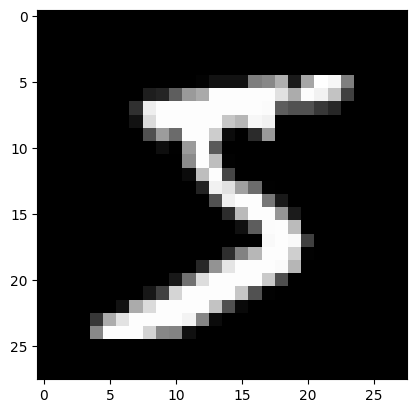

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap="gray", interpolation="nearest")

In [87]:
#print(X_train[0])

In [88]:
X_train.shape

(60000, 28, 28)

Vision Transformers expect 3D input (e.g., 224×224×3). MNIST images are 28×28 grayscale.

In [89]:
''' uses all RAM and crashes
X_train = tf.image.resize(tf.expand_dims(X_train, -1), [224, 224])
X_test = tf.image.resize(tf.expand_dims(X_test, -1), [224, 224])
X_train = tf.repeat(X_train, 3, axis=-1)  # Convert grayscale to 3-channel RGB
X_test = tf.repeat(X_test, 3, axis=-1)
'''

' uses all RAM and crashes\nX_train = tf.image.resize(tf.expand_dims(X_train, -1), [224, 224])\nX_test = tf.image.resize(tf.expand_dims(X_test, -1), [224, 224])\nX_train = tf.repeat(X_train, 3, axis=-1)  # Convert grayscale to 3-channel RGB\nX_test = tf.repeat(X_test, 3, axis=-1)\n'

In [90]:
import tensorflow as tf

def preprocess(image, label):
    image = tf.expand_dims(image, -1)  # Add channel dimension
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)  # Converts to 3 channels
    image = tf.cast(image, tf.float32) / 255.0

    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Random contrast
    return image, tf.one_hot(label, 10)

batch_size = 64


# Convert to tf.data.Dataset first
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle before splitting
ds = ds.shuffle(buffer_size=len(X_train), seed=42)

# Calculate split sizes
val_size = int(0.2 * len(X_train))

# Split before mapping/batching
val_ds = ds.take(val_size)
train_ds = ds.skip(val_size)

# Then map and batch separately
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

len(train_ds), len(val_ds)

(750, 188)

In [91]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("First image tensor:", images[0])
    print("First label:", labels[0])


Images shape: (64, 224, 224, 3)
Labels shape: (64, 10)
First image tensor: tf.Tensor(
[[[-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  ...
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]]

 [[-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  ...
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]]

 [[-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  ...
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]]

 ...

 [[-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  [-0.02180365 -0.02180365 -0.02180365]
  ...
  [-0.02180365 -0.02180365 -0.02180365

In [93]:
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from transformers import DefaultDataCollator

model = TFViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224', num_labels=10)


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/347M [00:00<?, ?B/s]

ValueError: cannot reshape array of size 768000 into shape (768,10)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_mnist_model.h5", save_best_only=True)

In [ ]:
len(train_ds)

 the shape of the input is (batch_size, 224, 224, 3)

In [ ]:
for image_batch, _ in train_ds.take(1):
    print(image_batch.shape)


In [ ]:
for image_batch, _ in val_ds.take(1):
    print(image_batch.shape)

In [ ]:
# Train the model using the augmented train_ds in batches
history = model.fit(
    train_ds,  # The augmented training dataset with batching
    epochs=2,
    validation_data=val_ds,  # The validation dataset (no augmentation)
    callbacks=[early_stop, checkpoint]  # Early stopping and model checkpoint callbacks
)


In [ ]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs_range, history.history['accuracy'], label="Training accuracy", color='blue')
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Training vs Validation accuracy")
plt.legend()
plt.show()